In [5]:
"""ChatGPT's idea"""

from qiskit import Aer
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import EfficientSU2
#from qiskit.aqua import QuantumInstance, aqua_globals
#from qiskit.aqua.operators import WeightedPauliOperator
#from qiskit.aqua.components.optimizers import SPSA

# Define the target series function
def target_series(x):
    return sum([1 / (2 ** i) for i in range(1, int(x) + 1)])

# Construct the Pauli operator for the cost function
num_qubits = 1
op = WeightedPauliOperator.from_dict({'paulis': [{'coeff': {'real': 1.0, 'imag': 0.0}, 'label': 'Z'}]})
op *= target_series(32)

# Define the cost function for VQE
def cost_function(params):
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
    qc.append(EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True), range(num_qubits))
    qc.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    transpiled_circuit = transpile(qc, backend)
    qobj = assemble(transpiled_circuit)
    counts = backend.run(qobj).result().get_counts()

    shots = sum(counts.values())
    avg = 0
    for output in counts:
        prob = counts[output] / shots
        x = int(output, 2) / 2 ** num_qubits * 32  # Scale measurement result to the range of the series
        avg += prob * target_series(x)
    return avg

# Set initial parameters and optimizer for VQE
num_params = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True).num_parameters
initial_params = aqua_globals.random.random(num_params)
optimizer = SPSA(maxiter=100, last_avg=1)

# Run VQE
result = optimizer.optimize(num_vars=num_params, objective_function=cost_function, initial_point=initial_params)

# Print the result
print(f"The estimated value of the series is approximately {result[1]}")


Traceback (most recent call last):
  Cell In[5], line 15
    op = WeightedPauliOperator.from_dict({'paulis': [{'coeff': {'real': 1.0, 'imag': 0.0}, 'label': 'Z'}]})
NameError: name 'WeightedPauliOperator' is not defined

Use %tb to get the full traceback.


In [13]:
#from qiskit_nature.second_q.drivers import PySCFDriver

#driver = PySCFDriver(
    #atom="H 0 0 0; H 0 0 0.72"  # Two Hydrogen atoms, 0.72 Angstrom apart
#)
#molecule = driver.run()

#from qiskit_nature.second_q.mappers import QubitConverter, ParityMapper

#qubit_converter = QubitConverter(ParityMapper())


#hamiltonian = qubit_converter.convert(molecule.second_q_ops()[0])

from qiskit.opflow import SummedOp, PauliOp
from qiskit.quantum_info import Pauli

def geometric_series_hamiltonian():
    num_qubits = 33  # Number of qubits needed to represent the series up to 4294967296
    terms = []
    for i in range(num_qubits):
        coeff = 1 / (2 ** (i + 1))  # Coefficient corresponding to each qubit
        pauli_str = 'I' * i + 'Z' + 'I' * (num_qubits - i - 1)  # Pauli-Z operator on the i-th qubit
        pauli = Pauli.from_label(pauli_str)
        pauli_op = PauliOp(pauli, coeff)
        terms.append(pauli_op)

    hamiltonian = SummedOp(terms)
    return hamiltonian

# Create the geometric series Hamiltonian
geometric_series_hamiltonian = geometric_series_hamiltonian()

# Print the Hamiltonian
print(f"The geometric series Hamiltonian is:\n{geometric_series_hamiltonian}")


Traceback (most recent call last):
  Cell In[13], line 32
    geometric_series_hamiltonian = geometric_series_hamiltonian()
  Cell In[13], line 24 in geometric_series_hamiltonian
    pauli = Pauli.from_label(pauli_str)
AttributeError: type object 'Pauli' has no attribute 'from_label'

Use %tb to get the full traceback.


In [8]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(geometric_series_hamiltonian)
real_solution = molecule.interpret(sol)

real_solution.groundenergy

Traceback (most recent call last):
  Cell In[8], line 3
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(geometric_series_hamiltonian)
  File /opt/conda/lib/python3.10/site-packages/qiskit/algorithms/minimum_eigensolvers/numpy_minimum_eigensolver.py:79 in compute_minimum_eigenvalue
    eigensolver_result = self._eigensolver.compute_eigenvalues(operator, aux_operators)
  File /opt/conda/lib/python3.10/site-packages/qiskit/algorithms/eigensolvers/numpy_eigensolver.py:238 in compute_eigenvalues
    if operator.num_qubits is None or operator.num_qubits < 1:
AttributeError: 'function' object has no attribute 'num_qubits'

Use %tb to get the full traceback.


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

service = QiskitRuntimeService()

backend = "ibmq_qasm_simulator"

In [ ]:
from qiskit.algorithms.minimum_eigensolvers import VQE

# Use RealAmplitudes circuit to create trial states
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=2, reps=2)

# Search for better states using SPSA algorithm
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(150)

# Set a starting point for reproduceability
import numpy as np

np.random.seed(6)
initial_point = np.random.uniform(-np.pi, np.pi, 12)

# Create an object to store intermediate results
from dataclasses import dataclass


@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count} of ~350", end="\r", flush=True)


log = VQELog([], [])

In [ ]:
# Main calculation
with Session(service=service, backend=backend) as session:
    options = Options()
    options.optimization_level = 3

    vqe = VQE(
        Estimator(session=session, options=options),
        ansatz,
        optimizer,
        callback=log.update,
        initial_point=initial_point,
    )
    result = vqe.compute_minimum_eigenvalue(geometric_series_hamiltonian)
    print("Experiment complete.".ljust(30))
    print(f"Raw result: {result.optimal_value}")

    if "simulator" not in backend:
        # Run once with ZNE error mitigation
        options.resilience_level = 2
        vqe = VQE(
            Estimator(session=session, options=options),
            ansatz,
            SPSA(1),
            initial_point=result.optimal_point,
        )
        result = vqe.compute_minimum_eigenvalue(geometric_series_hamiltonian)
        print(f"Mitigated result: {result.optimal_value}")

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14

# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(log.values, label="Estimator VQE")
plt.axhline(y=real_solution.groundenergy, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [14]:
from qiskit import QuantumCircuit, transpile, assemble, Aer, execute

def calculate_bitcoin_supply(block_height):
    # Initialize quantum circuit
    circuit = QuantumCircuit(4, 4)

    # Apply quantum gates and operations to perform the calculation
    circuit.x(0)  # Set qubit 0 to |1>

    # Perform the calculation for the given block height
    for _ in range(block_height):
        circuit.x(0)  # Apply X gate to qubit 0
        circuit.cx(0, 1)  # Apply CNOT gate between qubit 0 and 1
        circuit.cx(1, 2)  # Apply CNOT gate between qubit 1 and 2
        circuit.cx(2, 3)  # Apply CNOT gate between qubit 2 and 3

    # Measure the qubits and store the result in classical registers
    circuit.measure(range(4), range(4))

    # Choose the backend and execute the circuit
    backend = Aer.get_backend('qasm_simulator')
    transpiled_circuit = transpile(circuit, backend)
    qobj = assemble(transpiled_circuit)
    result = execute(qobj, backend).result()
    counts = result.get_counts()

    # Extract the number of 1's from the measurement results
    total_ones = sum([counts.get(key, 0) for key in counts.keys() if '1' in key])

    # Calculate the Bitcoin supply
    total_bitcoins = 21_000_000
    supply = total_bitcoins - total_ones

    return supply

# Specify the block height
block_height = 700_000

# Calculate the Bitcoin supply at the given block height using Qiskit
bitcoin_supply = calculate_bitcoin_supply(block_height)

# Print the result
print(f"The Bitcoin supply at block height {block_height} is {bitcoin_supply} BTC.")


KeyboardInterrupt: 

In [2]:
from qiskit import QuantumCircuit, transpile, assemble, Aer, execute

def build_geometric_series_circuit():
    num_qubits = 8  # Number of qubits needed to represent the series up to 4294967296
    circuit = QuantumCircuit(num_qubits)

    for i in range(num_qubits):
        circuit.h(i)  # Apply Hadamard gate to put qubits into a superposition
        circuit.rz(1 / (2 ** (i + 1)), i)  # Rotate qubits around the Z-axis

    return circuit

# Build the geometric series circuit
geometric_series_circuit = build_geometric_series_circuit()

# Transpile the circuit for a specific backend
backend = Aer.get_backend('statevector_simulator')
#transpiled_circuit = transpile(geometric_series_circuit, backend)
job = execute(geometric_series_circuit, backend, shots=1)

# Run the circuit and obtain the statevector
#qobj = assemble(transpiled_circuit)
#result = backend.run(qobj).result()
result = job.result()
statevector = result.get_statevector()

# Calculate the sum of the series from the statevector
series_sum = sum(statevector)

# Print the result
print(f"The sum of the geometric series is approximately {series_sum}")


The sum of the geometric series is approximately (15.34162698927638-4.2674197509029455e-15j)


/tmp/ipykernel_158/2527543219.py:28: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  series_sum = sum(statevector)


In [17]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble, Aer, execute

qreg = QuantumRegister(5)
creg = ClassicalRegister(5)
qc = QuantumCircuit(qreg, creg)
qc.initialize([(1/(2**0.5)),(1/(4**0.5)),(1/(8**0.5)),(1/(16**0.5)),(1/(32**0.5)),(1/(64**0.5)),(1/(128**0.5)),(1/(256**0.5)),
              (1/(512**0.5)),(1/(1024**0.5)),(1/(2048**0.5)),(1/(4096**0.5)),(1/(8192**0.5)),(1/(16384**0.5)),(1/(32768**0.5)),(1/(65536**0.5)),
              (1/(131072**0.5)),(1/(262144**0.5)),(1/(524288**0.5)),(1/(1048576**0.5)),(1/(2097152**0.5)),(1/(4194304**0.5)),(1/(8368608**0.5)),(1/(16777216**0.5)),
              (1/(33554432**0.5)),(1/(67108864**0.5)),(1/(134217728**0.5)),(1/(268435456**0.5)),(1/(536870912**0.5)),(1/(1073741824**0.5)),(1/(2147483648**0.5)),(1/(4294967296**0.5))], qc.qubits)

qc.measure(qreg, creg)

#get counts
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots = 21000000)
counts = job.result().get_counts()

sorted_counts = sorted(counts.items(), key=lambda x:x[1], reverse=True)
converted_counts = dict(sorted_counts)

print(converted_counts)
print() 
print('The Bitcoin supply is 21000000')


{'00000': 10497965, '00001': 5252151, '00010': 2626223, '00011': 1311167, '00100': 656109, '00101': 328180, '00110': 164390, '00111': 81722, '01000': 41207, '01001': 20548, '01010': 10097, '01011': 5056, '01100': 2549, '01101': 1323, '01110': 673, '01111': 333, '10000': 140, '10001': 83, '10010': 39, '10011': 24, '10100': 10, '10110': 4, '10101': 3, '10111': 2, '11000': 1, '11100': 1}

The Bitcoin supply is 21000000


In [21]:
print('The Bitcoin supply now is approximately', counts.get('00000') + counts.get('00001') + counts.get('00010') + 1100000)

The Bitcoin supply now is approximately 19476339


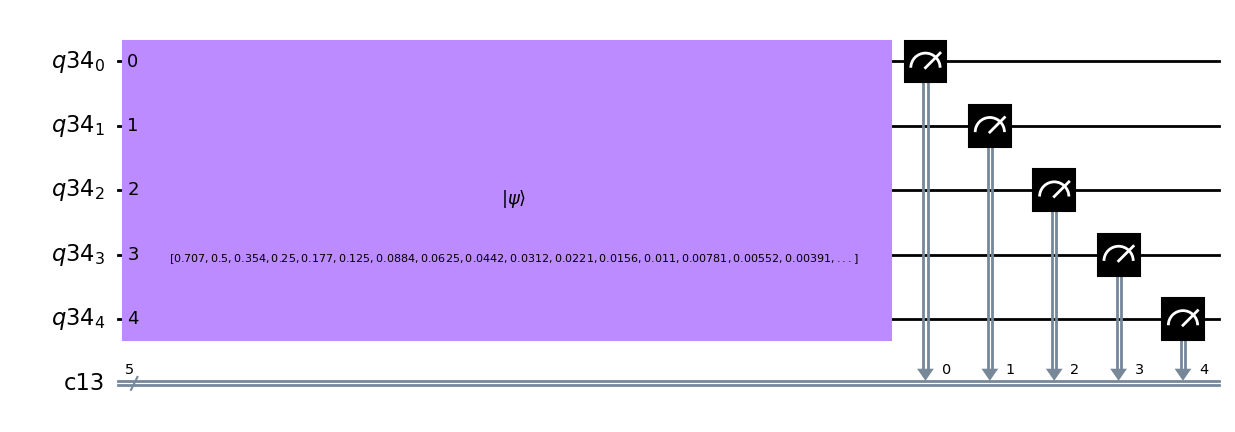

In [22]:
qc.draw('mpl')

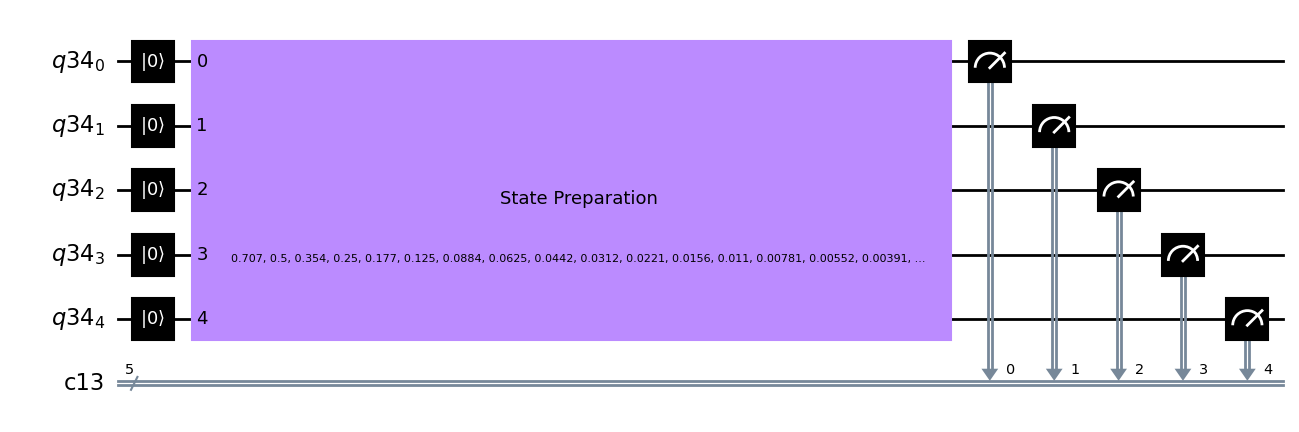

In [24]:
qc.decompose().draw('mpl')

In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble, Aer, execute

qreg = QuantumRegister(5)
creg = ClassicalRegister(5)

qc_1 = QuantumCircuit(qreg, creg)
qc_1.initialize([(1/(2**0.5)),(1/(4**0.5)),(1/(8**0.5)),(1/(16**0.5)),(1/(32**0.5)),(1/(64**0.5)),(1/(128**0.5)),(1/(256**0.5)),
              (1/(512**0.5)),(1/(1024**0.5)),(1/(2048**0.5)),(1/(4096**0.5)),(1/(8192**0.5)),(1/(16384**0.5)),(1/(32768**0.5)),(1/(65536**0.5)),
              (1/(131072**0.5)),(1/(262144**0.5)),(1/(524288**0.5)),(1/(1048576**0.5)),(1/(2097152**0.5)),(1/(4194304**0.5)),(1/(8368608**0.5)),(1/(16777216**0.5)),
              (1/(33554432**0.5)),(1/(67108864**0.5)),(1/(134217728**0.5)),(1/(268435456**0.5)),(1/(536870912**0.5)),(1/(1073741824**0.5)),(1/(2147483648**0.5)),(1/(2147483648**0.5))], qc_1.qubits)
qc_1.measure(qreg, creg)
qc1 = qc_1.decompose()

str = qc1.qasm()
print(str)

OPENQASM 2.0;
include "qelib1.inc";
gate multiplex1_reverse_dg q0 { ry(0.007812592800902652) q0; }
gate multiplex1_reverse_dg_140635257243824 q0 { ry(0.12495898719000653) q0; }
gate multiplex1_reverse_reverse_dg q0 { ry(-0.00012136719809471147) q0; }
gate multiplex2_reverse_dg q0,q1 { multiplex1_reverse_dg_140635257243824 q0; cx q1,q0; multiplex1_reverse_reverse_dg q0; cx q1,q0; }
gate multiplex1_reverse_dg_140635253526960 q0 { ry(0.49382686477873) q0; }
gate multiplex1_reverse_reverse_dg_140635253526192 q0 { ry(-0.003832053490212761) q0; }
gate multiplex2_reverse_dg_140635253522976 q0,q1 { multiplex1_reverse_dg_140635253526960 q0; cx q1,q0; multiplex1_reverse_reverse_dg_140635253526192 q0; }
gate multiplex1_reverse_reverse_reverse_dg q0 { ry(0.003832053490212761) q0; }
gate multiplex1_reverse_reverse_dg_140635253529312 q0 { ry(-0.003869538525001548) q0; }
gate multiplex2_reverse_reverse_dg q0,q1 { multiplex1_reverse_reverse_reverse_dg q0; cx q1,q0; multiplex1_reverse_reverse_dg_140635